# Sampler

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.data import make_dataloaders, save_model, DotDict
from models.VAE import VanillaVAE, IWAE, NeqVAE#, FlowVAE
from models.evidence import Estimator, NonEq_Estimator_w_a, AIS_Estimator
from utils.targets import Gaussian_target, Gaussian_mixture, Uniform, BNAF_examples, Funnel, Banana_32
from models.sampler import Neq_Gibbs_sampler, ISIR

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
import pdb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torchType = torch.float32



## Mixture of Gaussian xp

In [30]:
### Fixing seed
seed = 54
np.random.seed(seed)
torch.manual_seed(seed)

In [31]:
args = DotDict()
args.h = 0.1 ###should be prop to sigma/dim ? 
args.gamma = -1.
args.name = 'DampedHamiltonian'# so far implemented : 'LeapFrog', 'DampedHamiltonian', 'Identity'
dim = 40
K = 10
#a, a_string = torch.tensor(np.exp(-1.*np.arange(K)*dim*args.gamma*args.h)), 'exp(-dim*gamma*h*range(K))'
a, a_string  = torch.ones(K), 'ones(K)'
args.estimation = True


argsp = DotDict()
argsp.mu = torch.zeros(dim)
argsp.cov = 2.*torch.eye(dim)
argsp.device = device
argsp.torchType=torchType
prior = torch.distributions.MultivariateNormal(loc=argsp.mu, covariance_matrix=argsp.cov)
importance_distr = torch.distributions.MultivariateNormal(loc=argsp.mu, covariance_matrix=argsp.cov)

In [32]:
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss//n_col
s= 1
u = torch.ones(dim)
#sigma=0.01
###create points
var_mix= .01
var_rest = 0.1
sigma_vec = torch.tensor([var_mix, var_mix]+ [var_rest]*(dim-2))
target_args.p_gaussians = [torch.tensor(.5)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (dim- 2), device = device, dtype = torchType) for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [sigma_vec*torch.eye(dim, device = device, dtype = torchType)]*target_args.num_gauss

#target_args.p_gaussians = [torch.tensor(.5)]*target_args.num_gauss
#target_args.locs = [-s*u, s*u]
#target_args.covs = [sigma*torch.eye(dim)]*target_args.num_gauss

target_args.dim=dim
target = Gaussian_mixture(target_args)
loglikelihood = lambda z, x=None: (target.log_prob(z, x)).view(prior.log_prob(z).shape) - prior.log_prob(z).detach()

In [33]:
alpha = -0.1
logvar_p = -1.*torch.log(torch.tensor(sigma_vec, dtype = torch.float32)) 
logvar_p_transfo = alpha *torch.log(torch.tensor(sigma_vec, dtype = torch.float32))

<ipython-input-33-9f33285bbe0e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logvar_p = -1.*torch.log(torch.tensor(sigma_vec, dtype = torch.float32))
<ipython-input-33-9f33285bbe0e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logvar_p_transfo = alpha *torch.log(torch.tensor(sigma_vec, dtype = torch.float32))


In [34]:
n_samples = 10
len_chain = 40000
n_chain = 1
sampler = Neq_Gibbs_sampler(dim=dim, num_samples=n_samples, prior=prior, 
                            importance_distr=importance_distr, transformation_params=args, 
                            a=a, verbose = False,
                            logvar_p = logvar_p, logvar_p_transfo = logvar_p_transfo)

isir = ISIR(dim=dim, num_samples=n_samples, prior=prior, 
                            importance_distr=importance_distr, verbose = False)

In [35]:
samples, n_eff = sampler.chain_sample(len_chain,  n_chain, loglikelihood, None)

  0%|          | 0/40000 [00:00<?, ?it/s]/home/achille/Documents/GitCodes/Non_equilibrium_VAE/InFiNE_code/utils/targets.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.mixture.log_prob(z) + torch.log(torch.tensor(torch.sum(self.pis)))
100%|██████████| 40000/40000 [7:09:30<00:00,  1.55it/s]        


In [ ]:
samples_is, n_eff_is = isir.chain_sample(len_chain*K,  n_chain, loglikelihood, None)

 83%|████████▎ | 333652/400000 [8:25:35<14:22, 76.95it/s]        

In [ ]:
samples_plot = np.array(samples.view(-1, dim))


In [ ]:
plt.scatter(samples_plot[:,0], samples_plot[:,1], alpha = 0.2)

In [ ]:
n_eff

In [ ]:
n_eff_is

In [ ]:
samples_plot_is = np.array(samples_is.view(-1, dim))

In [ ]:
plt.scatter(samples_plot_is[:,0], samples_plot_is[:,1], alpha = 0.002)

In [ ]:
import pyro

In [ ]:
kernel = pyro.infer.HMC

In [ ]:
from pyro.infer import MCMC, NUTS, HMC

def energy(z):
    z = z['points']
    return -target.log_prob(z, None).sum()


#kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = 4)
kernel = NUTS(potential_fn=energy)
init_samples = prior.sample((n_chain,))

init_params = {'points': init_samples}
mcmc = MCMC(kernel=kernel, num_samples = 50000, initial_params=init_params)
mcmc.run()

q_new = mcmc.get_samples(group_by_chain=True)["points"].squeeze()

In [ ]:
samples_plot_nuts = np.array(q_new.view(-1, dim))


In [ ]:
plt.scatter(samples_plot_nuts[:,0], samples_plot_nuts[:,1], alpha = 0.02)

In [ ]:
def plot_hist(samples, title = 'Histogram', bins=200, 
              gamma=0.5, ax_lims = [(-5,5), (-5,5)], 
              save_path = 'pics/histogram_test.pdf', density = True):
    plt.close()
    plt.figure(figsize=(5, 5), dpi=300)
    plt.hist2d(samples[:,0], samples[:,1],bins=bins, density=density, range=[ax_lims[0], ax_lims[1]],norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.axis('on')
    plt.xlim((ax_lims[0][0], ax_lims[0][1]))
    plt.ylim((ax_lims[1][0], ax_lims[1][1]))
    plt.savefig(save_path, bbox_inches='tight')
    plt.show() 
        

In [ ]:
plot_hist(samples_plot_is, title = '', gamma = 0.2,save_path = 'pics/histogram_isir.pdf')

In [ ]:
plot_hist(samples_plot, title = '',save_path = 'pics/histogram_infine.pdf', gamma = 0.4)

In [ ]:
plot_hist(samples_plot_nuts, title = '',save_path = 'pics/histogram_nuts.pdf', gamma = 0.4)

In [ ]:
samples_true = target.sample((10000,))
samples_true.shape

In [ ]:
plot_hist(np.array(samples_true), title = '',save_path = 'pics/histogram_true.pdf', gamma = 0.8)

# Funnel 16 d distribution

In [4]:
### Fixing seed
seed = 54
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
xmin = -5
xmax = 5
dim = 16
args_prior = DotDict()
args_prior.device = device
args_prior.torchType = torchType
args_prior.x_min = xmin
args_prior.x_max = xmax
args_prior.dim = dim
prior = Uniform(args_prior)
importance_distr = prior
##############################################
argsp = DotDict()
argsp.mu = torch.zeros(dim)
argsp.cov = 5.*torch.eye(dim)
argsp.device = device
argsp.torchType=torchType
prior = torch.distributions.MultivariateNormal(loc=argsp.mu, covariance_matrix=argsp.cov)
importance_distr = torch.distributions.MultivariateNormal(loc=argsp.mu, covariance_matrix=argsp.cov)
##############################################
args_target = DotDict
args_target.device = device
args_target.dim = dim
target = Funnel(args_target)
###############################################
loglikelihood = lambda z, x=None: (target.log_prob(z, x)).view(prior.log_prob(z).shape) - prior.log_prob(z).detach()

K = 10


In [6]:
from pyro.infer import MCMC, NUTS, HMC

def energy(z):
    z_ = z['points']
    return -target.log_prob(z_, None).sum()


kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
#kernel = NUTS(potential_fn=energy, full_mass = False)
init_samples = prior.sample((1,))

init_params = {'points': init_samples}
mcmc = MCMC(kernel=kernel, num_samples = 10000, initial_params=init_params)
mcmc.run()

q_new = mcmc.get_samples(group_by_chain=True)["points"].squeeze()

Sample: 100%|██████████| 20000/20000 [00:41, 477.59it/s, step size=2.63e-01, acc. prob=0.924]


In [7]:
mass = mcmc.kernel._adapter.inverse_mass_matrix
mass

tensor([0.7675, 1.5753, 1.4695, 1.5135, 1.5120, 1.4781, 1.4397, 1.5125, 1.5179,
        1.5563, 1.5923, 1.4463, 1.4947, 1.4670, 1.6852, 1.5691])

In [8]:
mcmc.kernel._adapter.step_size

0.26255798235247835

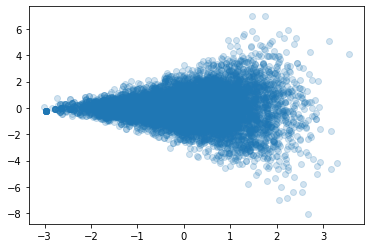

In [9]:
samples_plot_hmc = np.array(q_new.view(-1, dim))
plt.scatter(samples_plot_hmc[:,0], samples_plot_hmc[:,1], alpha = 0.2)

In [22]:
args = DotDict()
args.h = mcmc.kernel._adapter.step_size ###should be prop to sigma/dim ? 
args.gamma = -.2
args.name = 'DampedHamiltonian'# so far implemented : 'LeapFrog', 'DampedHamiltonian', 'Identity'
a, a_string  = torch.ones(K), 'ones(K)'
args.estimation = True
samples_grad = q_new.view(-1, dim).clone().requires_grad_(True)[:]
ll_samples = loglikelihood(samples_grad)
grad_ll = torch.autograd.grad(ll_samples.sum(), samples_grad)[0]
mass = torch.var(grad_ll, dim=0)
mass = mcmc.kernel._adapter.inverse_mass_matrix




logvar_p = - mass.log()
logvar_p_transfo = - mass.log()
#logvar_p = torch.zeros(1)
#logvar_p_transfo = torch.zeros(1)

In [23]:
mass

tensor([0.7675, 1.5753, 1.4695, 1.5135, 1.5120, 1.4781, 1.4397, 1.5125, 1.5179,
        1.5563, 1.5923, 1.4463, 1.4947, 1.4670, 1.6852, 1.5691])

In [24]:
n_samples = 20
len_chain = 40000
n_chain = 1
sampler = Neq_Gibbs_sampler(dim=dim, num_samples=n_samples, prior=prior, 
                            importance_distr=importance_distr, transformation_params=args, 
                            a=a, verbose = False,
                            logvar_p = logvar_p, logvar_p_transfo = logvar_p_transfo)

isir = ISIR(dim=dim, num_samples=n_samples, prior=prior, 
                            importance_distr=importance_distr, verbose = False)

In [25]:
samples2, n_eff2 = sampler.chain_sample(len_chain,  n_chain, loglikelihood, None)

100%|██████████| 10000/10000 [06:01<00:00, 27.68it/s]


In [ ]:
samples_is, n_eff_is = isir.chain_sample(len_chain*K,  n_chain, loglikelihood, None)

tensor(7052)

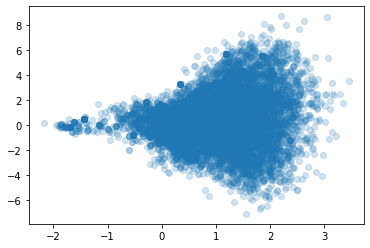

In [26]:
samples_plot2 = np.array(samples2.view(-1, dim))

plt.scatter(samples_plot2[:,0], samples_plot2[:,1], alpha = 0.2)
n_eff2

In [ ]:
samples_plot_is = np.array(samples_is.view(-1, dim))
plt.scatter(samples_plot_is[:,0], samples_plot_is[:,1], alpha = 0.02)
n_eff_is

In [15]:
def plot_hist(samples, title = 'Histogram', bins=100, 
              gamma=0.5, ax_lims = [(-5,5), (-10,10)], 
              save_path = 'pics/histogram_test.pdf', density = True):
    plt.close()
    plt.figure(figsize=(5, 5), dpi=300)
    plt.hist2d(samples[:,0], samples[:,1],bins=bins, density=density, range=[ax_lims[0], ax_lims[1]],norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.axis('off')
    plt.xlim((ax_lims[0][0], ax_lims[0][1]))
    plt.ylim((ax_lims[1][0], ax_lims[1][1]))
    #plt.savefig(save_path, bbox_inches='tight')
    plt.show() 

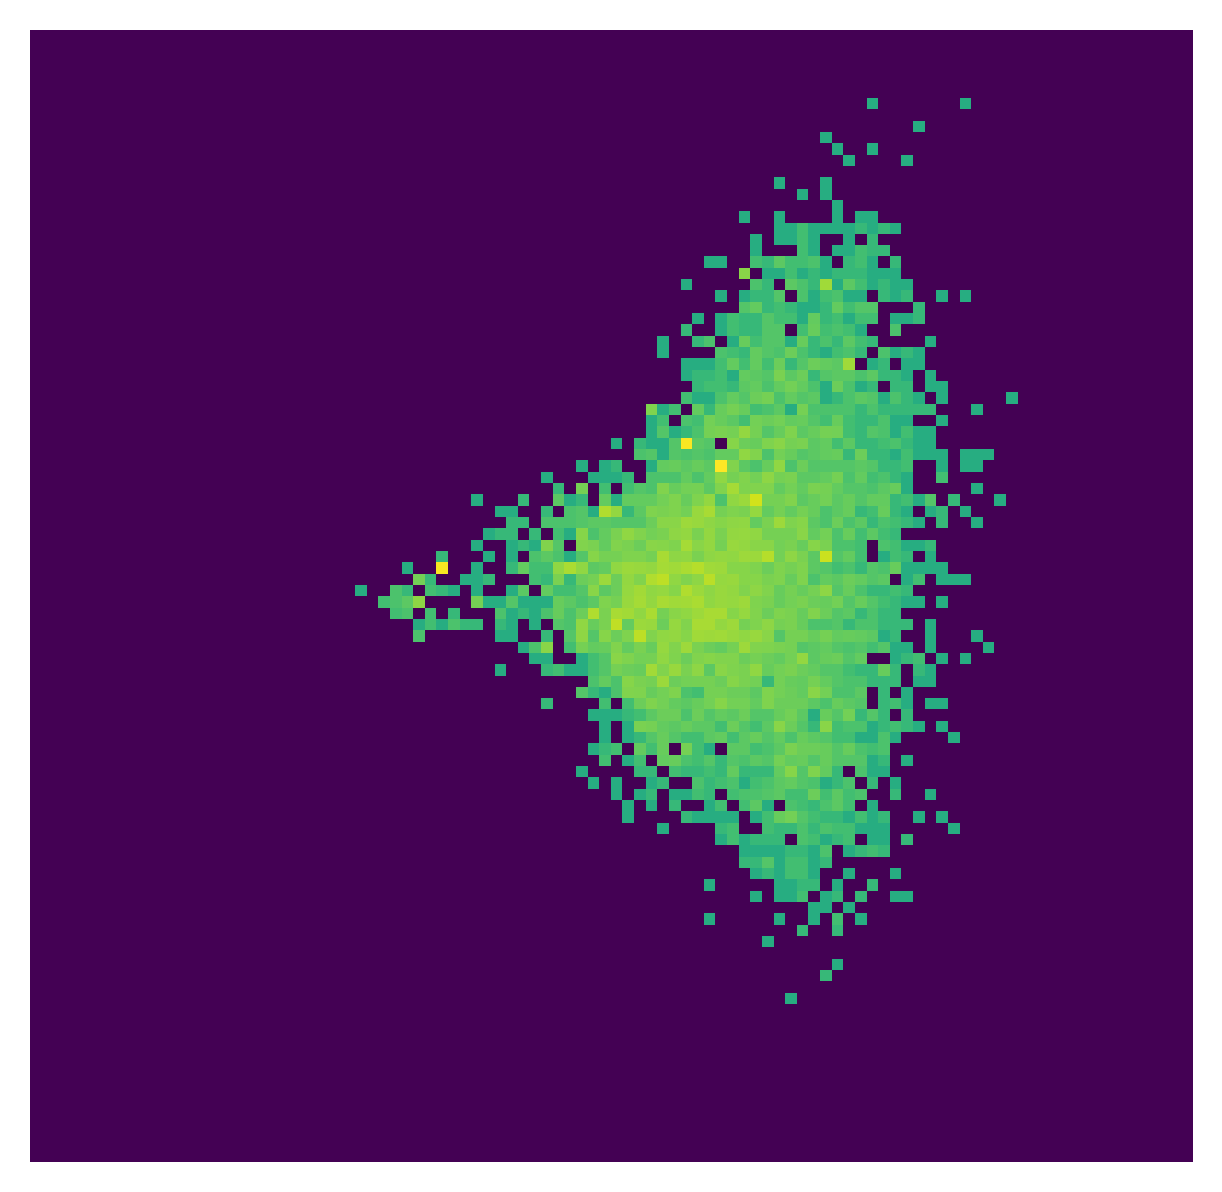

In [28]:
plot_hist(samples_plot2, title = '', gamma = 0.1,save_path = 'histogram_infine_funnel3.pdf')

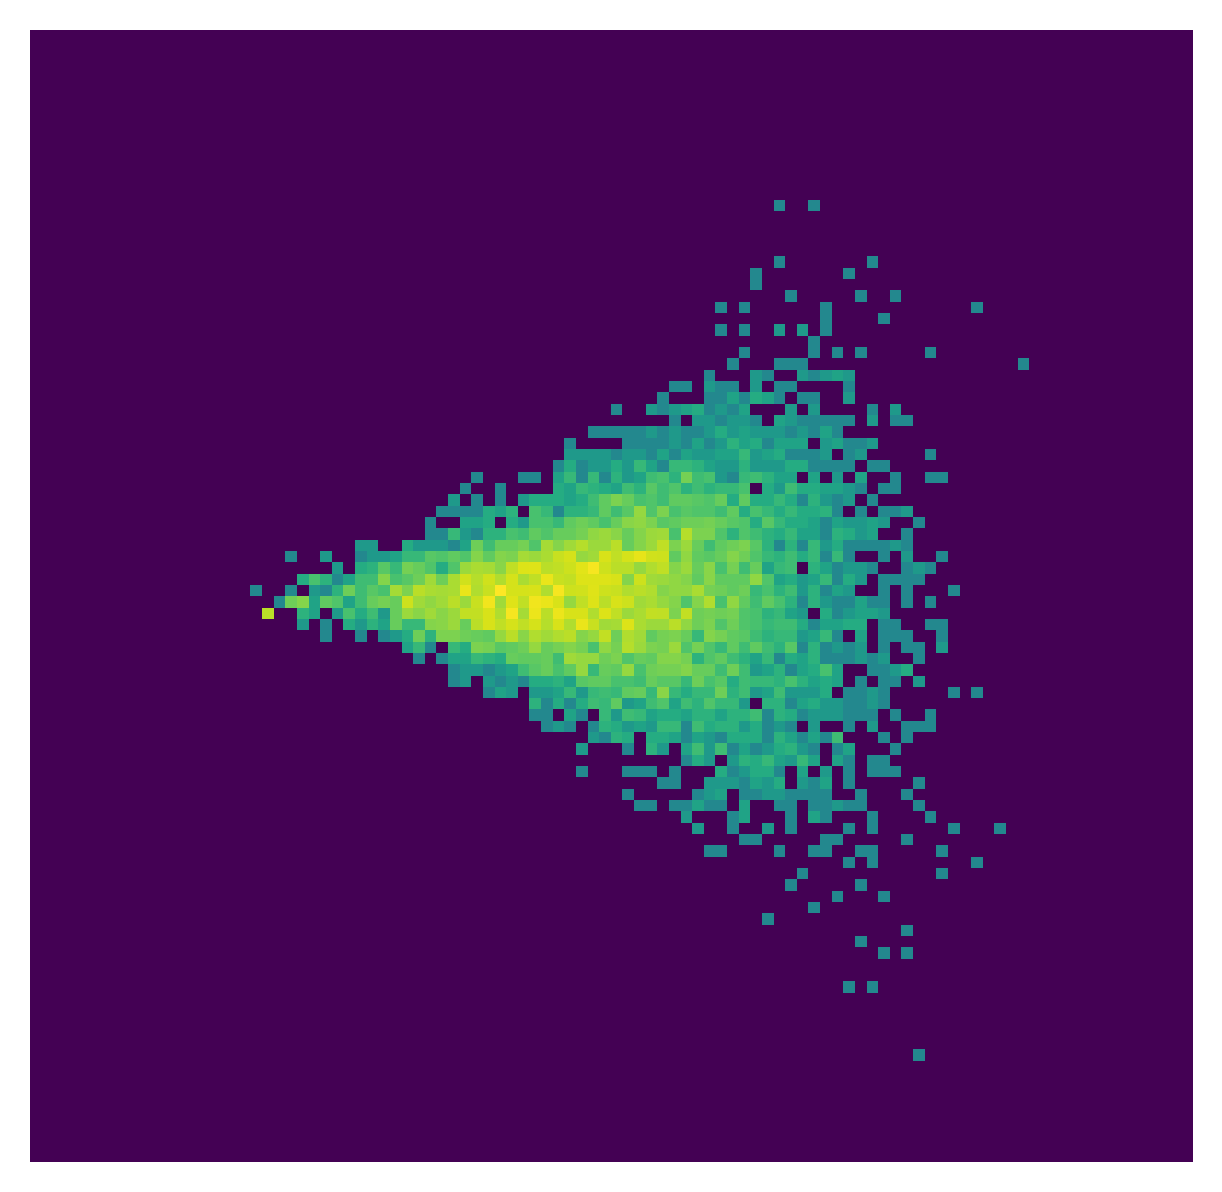

In [17]:
plot_hist(samples_plot_hmc, title = '', gamma = 0.2,save_path = 'pics/histogram_hmc_funnel1.pdf')

In [ ]:
plot_hist(samples_plot_is, title = '', gamma = 0.2,save_path = 'pics/histogram_isir_funnel1.pdf')

In [ ]:
from pyro.infer import MCMC, NUTS, HMC

def energy(z):
    z = z['points']
    return -target.log_prob(z, None).sum()


#kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
kernel_true = NUTS(potential_fn=energy, full_mass = False)
init_samples = prior.sample((1,))

init_params = {'points': init_samples}
mcmc_true = MCMC(kernel=kernel_true, num_samples = 100000, initial_params=init_params)
mcmc_true.run()

q_true = mcmc_true.get_samples(group_by_chain=True)["points"].squeeze()

In [ ]:
samples_plot_true = np.array(q_true.view(-1, dim))


In [ ]:
plot_hist(samples_plot_true, title = '', gamma = 0.2,save_path = 'pics/histogram_true_funnel1.pdf')